<a href="https://colab.research.google.com/gist/IamA1ive/bcfc646307bcbef29753d7c8107e3839/ml-student-performance-predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Student Performance Predictions
Задача: спрогнозировать результаты учащихся на основе различных академических и поведенческих факторов.
Датасет содержит случайные пропущенные значения и преднамеренные ошибки данных, что делает его более реалистичным для практики очистки и предварительной обработки данных.

In [277]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# Загружаем последнюю версию датасета с kaggle.com
path = kagglehub.dataset_download("haseebindata/student-performance-predictions")

print("Расположение датасета:", path)
df = pd.read_csv(os.path.join(path, "student_performance_updated_1000.csv"))

Расположение датасета: /root/.cache/kagglehub/datasets/haseebindata/student-performance-predictions/versions/4


# Прочитаем данные

In [278]:
print("\nРазмерность набора данных:", df.shape)
print("\nОбщая информация о наборе данных:\n")
df.info()
print("\nПервые и последние 5 строк набора данных:")
display(df.head())
display(df.tail())



Размерность набора данных: (1000, 12)

Общая информация о наборе данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   StudentID                  960 non-null    float64
 1   Name                       966 non-null    object 
 2   Gender                     952 non-null    object 
 3   AttendanceRate             960 non-null    float64
 4   StudyHoursPerWeek          950 non-null    float64
 5   PreviousGrade              967 non-null    float64
 6   ExtracurricularActivities  957 non-null    float64
 7   ParentalSupport            978 non-null    object 
 8   FinalGrade                 960 non-null    float64
 9   Study Hours                976 non-null    float64
 10  Attendance (%)             959 non-null    float64
 11  Online Classes Taken       975 non-null    object 
dtypes: float64(8), object(4)
memor

,StudentID,Name,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade,Study Hours,Attendance (%),Online Classes Taken
0,1.0,John,Male,85.0,15.0,78.0,1.0,High,80.0,4.8,59.0,False
1,2.0,Sarah,Female,90.0,20.0,85.0,2.0,Medium,87.0,2.2,70.0,True
2,3.0,Alex,Male,78.0,10.0,65.0,0.0,Low,68.0,4.6,92.0,False
3,4.0,Michael,Male,92.0,25.0,90.0,3.0,High,92.0,2.9,96.0,False
4,5.0,Emma,Female,NaN,18.0,82.0,2.0,Medium,85.0,4.1,97.0,True


,StudentID,Name,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade,Study Hours,Attendance (%),Online Classes Taken
995,NaN,Kenneth Murray,Male,85.0,20.0,NaN,1.0,High,72.0,0.8,80.0,True
996,4497.0,Amy Stout,Female,91.0,NaN,86.0,0.0,High,90.0,3.9,80.0,True
997,1886.0,NaN,Male,85.0,8.0,82.0,2.0,Low,68.0,0.4,54.0,False
998,7636.0,Joseph Sherman,Male,88.0,17.0,60.0,2.0,High,85.0,0.9,53.0,True
999,8021.0,Maria Walls,Female,88.0,10.0,90.0,1.0,Medium,NaN,2.4,94.0,True


Имеем:

`StudentID`	- уникальный номер каждого студента

`Name` - имя студента

`Gender` - пол студента (Male / Female)

`AttendanceRate` - общая оценка посещаемости

`StudyHoursPerWeek` - часы, затрачиваемые на обучение еженедельно

`PreviousGrade` - оценка с прошлого семестра

`ExtracurricularActivities` - количество внеклассных мероприятий

`ParentalSupport` - уровень родительской поддержки (High / Medium / Low)

`FinalGrade` - итоговая оценка (целевая для предсказания переменная)

`Study Hours` - часы, затрачиваемые на обучение ежедневно

`Attendance` (%) - доля посещённых занятий

`Online Classes Taken` - посещал ли студент онлайн-занятия (True / False).

In [279]:
print("Количество пропущенных значений:")
display(df.isnull().sum())
display(df.describe())

Количество пропущенных значений:


,0
StudentID,40
Name,34
Gender,48
AttendanceRate,40
StudyHoursPerWeek,50
PreviousGrade,33
ExtracurricularActivities,43
ParentalSupport,22
FinalGrade,40
Study Hours,24


,StudentID,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,FinalGrade,Study Hours,Attendance (%)
count,960.000000,960.000000,950.000000,967.000000,957.000000,960.000000,976.000000,959.000000
mean,5416.019792,85.510417,17.630526,77.598759,1.520376,80.030208,2.406967,77.248175
std,2653.748319,7.332125,6.272132,10.006640,1.046439,9.493652,1.620267,19.298148
min,1.000000,70.000000,8.000000,60.000000,0.000000,62.000000,-5.000000,50.000000
25%,3113.500000,82.000000,12.000000,70.000000,1.000000,72.000000,1.200000,63.000000
50%,5396.500000,88.000000,18.000000,78.000000,1.000000,80.000000,2.500000,76.000000
75%,7754.750000,91.000000,22.000000,86.000000,2.000000,88.000000,3.700000,89.000000
max,9998.000000,95.000000,30.000000,90.000000,3.000000,92.000000,5.000000,200.000000


# Обработаем пропущенные значения

In [280]:
# Найдём дубликаты
print("Количество одинаковых строк:", df.duplicated().sum())
print("Процент уникальных имён:", round(100 * df["Name"].dropna().nunique() / len(df["Name"].dropna()), 2), "%")
# Удалим пропущенные значения
print("Процент строк с пропущенными значениями:", 100 * (1 - len(df.dropna()) / len(df)), "%")

Количество одинаковых строк: 0
Процент уникальных имён: 99.59 %
Процент строк с пропущенными значениями: 35.5 %


Видим, что строки с пропущенными значениями занимают значительную часть всего датасета и строк в таблице станет намного меньше после их удаления.

Для нашего датасета это критично, поэтому для того, чтобы минимизировать ущерб от наличия пропущенных значений, вместо удаления сотен строк из датасета - удалим столбцы `id` и `name`, так как в них содержится большое количество пропущенных значений, но сами признаки при этом не влияют на оценку студента.
Это позволит упростить модель и избежать использования нерелевантных данных на этапе обучения. Для остальных числовых признаков заменим пропущенные значения на медиану, так как она более устойчива к выбросам, чем среднее.

In [281]:
df = df.drop("Name", axis=1).drop("StudentID", axis=1)
numerical_cols = df.select_dtypes(include='float64').columns
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Gender                     952 non-null    object 
 1   AttendanceRate             1000 non-null   float64
 2   StudyHoursPerWeek          1000 non-null   float64
 3   PreviousGrade              1000 non-null   float64
 4   ExtracurricularActivities  1000 non-null   float64
 5   ParentalSupport            978 non-null    object 
 6   FinalGrade                 1000 non-null   float64
 7   Study Hours                1000 non-null   float64
 8   Attendance (%)             1000 non-null   float64
 9   Online Classes Taken       975 non-null    object 
dtypes: float64(7), object(3)
memory usage: 78.3+ KB


# Обработаем категориальные признаки

In [282]:
# Посмотрим на возможные значения категориальных признаков
categorical_cols = ["Gender", "ParentalSupport", "Online Classes Taken"]
for col in categorical_cols:
  print(df[col].unique())

['Male' 'Female' nan]
['High' 'Medium' 'Low' nan]
[False True nan]


In [284]:
# Заменим пропущенные значения категориальных признаков на моду
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Gender                     1000 non-null   object 
 1   AttendanceRate             1000 non-null   float64
 2   StudyHoursPerWeek          1000 non-null   float64
 3   PreviousGrade              1000 non-null   float64
 4   ExtracurricularActivities  1000 non-null   float64
 5   ParentalSupport            1000 non-null   object 
 6   FinalGrade                 1000 non-null   float64
 7   Study Hours                1000 non-null   float64
 8   Attendance (%)             1000 non-null   float64
 9   Online Classes Taken       1000 non-null   bool   
dtypes: bool(1), float64(7), object(2)
memory usage: 71.4+ KB


In [286]:
# Закодируем категориальные признаки
df["Gender"] = df["Gender"].replace({
    "Female": 0,
    "Male": 1
})
df["ParentalSupport"] = df["ParentalSupport"].replace({
    "Low": 0,
    "Medium": 1,
    "High": 2
})
df["Online Classes Taken"] = df["Online Classes Taken"].replace({
    False: 0,
    True: 1
})
df.describe()

,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade,Study Hours,Attendance (%),Online Classes Taken
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,0.549000,85.610000,17.649000,77.612000,1.498000,1.062000,80.029000,2.409200,77.197000,0.52000
std,0.497842,7.200399,6.113688,9.840238,1.029104,0.817817,9.301649,1.600749,18.899613,0.49985
min,0.000000,70.000000,8.000000,60.000000,0.000000,0.000000,62.000000,-5.000000,50.000000,0.00000
25%,0.000000,82.000000,12.000000,70.000000,1.000000,0.000000,72.000000,1.200000,64.000000,0.00000
50%,1.000000,88.000000,18.000000,78.000000,1.000000,1.000000,80.000000,2.500000,76.000000,1.00000
75%,1.000000,91.000000,22.000000,86.000000,2.000000,2.000000,88.000000,3.700000,89.000000,1.00000
max,1.000000,95.000000,30.000000,90.000000,3.000000,2.000000,92.000000,5.000000,200.000000,1.00000


Видим, что в столбцах `Study Hours` и `Attendance (%)` есть выбросы. Какой-то студент умудрился учиться -5 часов ежедневно, в то время как другой студент посещал занятия сразу за двоих. Совпадение? Так или иначе, нам нужно обработать эти выбросы путём замены их на медиану, при этом исключив эти выбросы во время её расчёта, чтобы аномальные значения не исказили её.

In [287]:
study_hours_median = df[(df["Study Hours"] >= 0) & (df["Study Hours"] <= 5)]["Study Hours"].median()
attendance_median = df[(df["Attendance (%)"] >= 0) & (df["Attendance (%)"] <= 100)]["Attendance (%)"].median()

df.loc[df["Study Hours"] < 0, "Study Hours"] = study_hours_median
df.loc[df["Attendance (%)"] > 100, "Attendance (%)"] = attendance_median


print("Статистика после обработки выбросов:")
display(df.describe())

Статистика после обработки выбросов:


,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade,Study Hours,Attendance (%),Online Classes Taken
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,0.549000,85.610000,17.649000,77.612000,1.498000,1.062000,80.029000,2.484200,75.957000,0.52000
std,0.497842,7.200399,6.113688,9.840238,1.029104,0.817817,9.301649,1.416805,14.307825,0.49985
min,0.000000,70.000000,8.000000,60.000000,0.000000,0.000000,62.000000,0.000000,50.000000,0.00000
25%,0.000000,82.000000,12.000000,70.000000,1.000000,0.000000,72.000000,1.200000,64.000000,0.00000
50%,1.000000,88.000000,18.000000,78.000000,1.000000,1.000000,80.000000,2.500000,76.000000,1.00000
75%,1.000000,91.000000,22.000000,86.000000,2.000000,2.000000,88.000000,3.700000,88.000000,1.00000
max,1.000000,95.000000,30.000000,90.000000,3.000000,2.000000,92.000000,5.000000,100.000000,1.00000


# Визуализируем данные и вычислим основные характеристики
Теперь, когда данные предобработаны и очищены, можно их визуализировать и дать начальную интерпретацию.

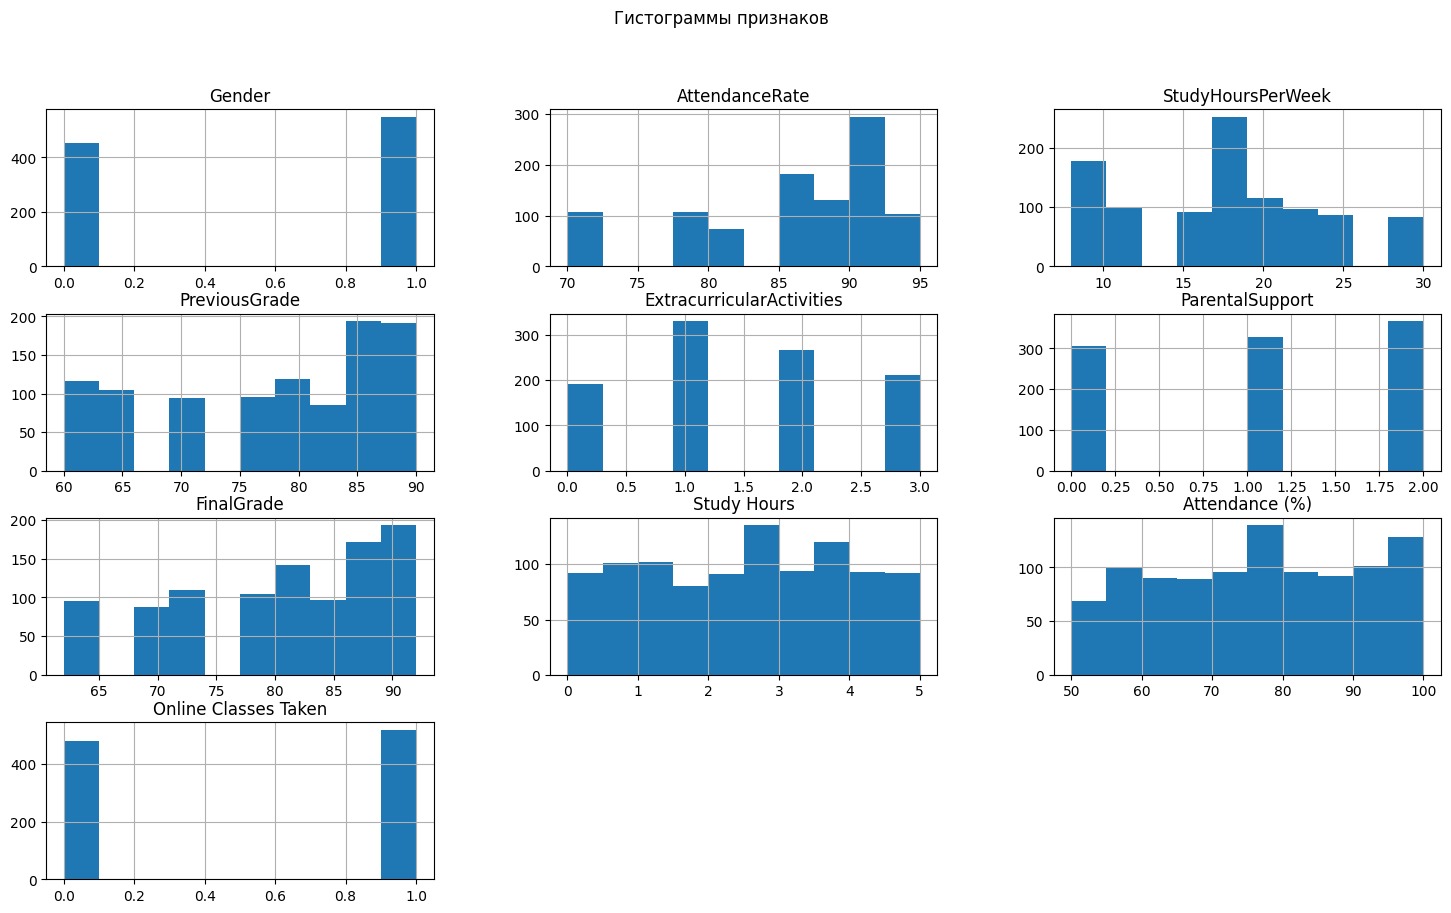

In [288]:
df.hist(bins=10, figsize=(18, 10))
plt.suptitle("Гистограммы признаков")
plt.show()

Видим, что:
* мужчин чуть больше из-за того, что на этапе обработки данных пропущенные значения были заменены модой
* студентов с родительской поддержкой высокого уровня чуть больше, чем остальных (по той же причине)
* онлайн-занятия посещали примерно половина студентов
* довольно много студентов с высокой итоговой оценкой и оценкой за прошлый семестр
* подавляющее большинство студентов участвовали во внеклассных мероприятиях хотя бы один раз

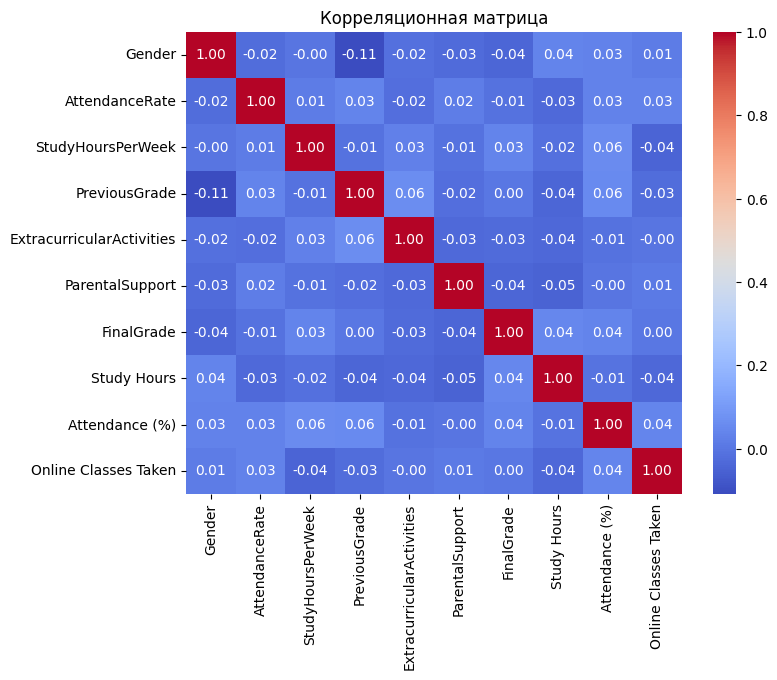

In [289]:
plt.figure(figsize=(8, 6))

corr_matrix = df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица')
plt.show()

Явно коррелирующих признаков нет. Это хорошо, так как все признаки несут в себе независимую информацию и исключать их не придётся.

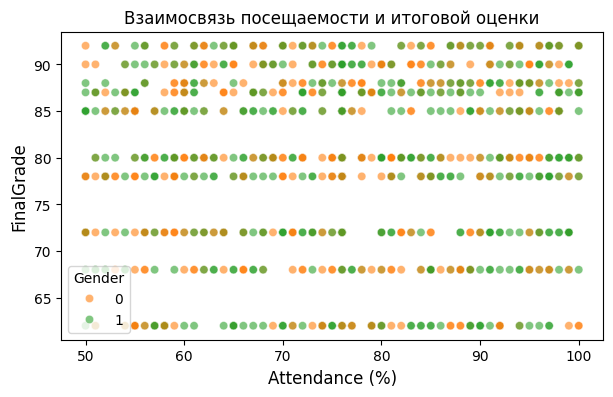

In [290]:
plt.figure(figsize=(7, 4))
sns.scatterplot(data=df, x='Attendance (%)', y='FinalGrade', hue='Gender', alpha=0.6, palette=['#ff7f0e', '#2ca02c'])
plt.title('Взаимосвязь посещаемости и итоговой оценки', fontsize=12)
plt.xlabel('Attendance (%)', fontsize=12)
plt.ylabel('FinalGrade', fontsize=12)
plt.legend(title='Gender')
plt.show()

Среди людей с высокой (от 85) оценкой чуть больше мужчин.

Среди людей с высокой (от 90%) посещаемостью чуть больше мужчин.

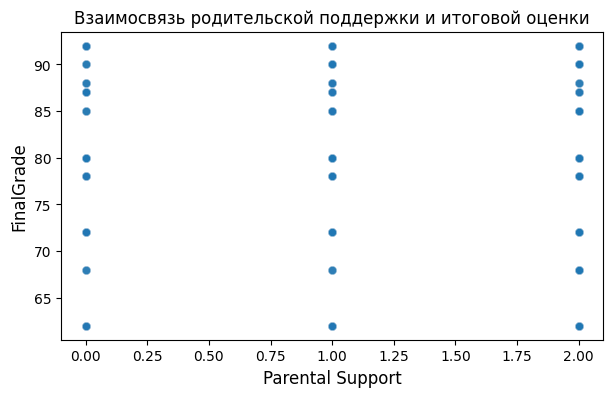

In [300]:
plt.figure(figsize=(7, 4))
sns.scatterplot(data=df, x='ParentalSupport', y='FinalGrade', alpha=0.1)
plt.title('Взаимосвязь родительской поддержки и итоговой оценки', fontsize=12)
plt.xlabel('Parental Support', fontsize=12)
plt.ylabel('FinalGrade', fontsize=12)
plt.show()

Люди с высокой родительской поддержкой могут плохо учиться, в то время как люди с низкой родительской поддержкой могут учиться превосходно. И тех, и других одинаково много.

# Проведём нормализацию

In [292]:
# Проведём нормализацию числовых признаков, не затрагивая целевую переменную
numerical_cols = ['AttendanceRate', 'StudyHoursPerWeek', 'PreviousGrade', 'ExtracurricularActivities', 'Study Hours', 'Attendance (%)']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("Статистика после нормализации:")
display(df.describe())

Статистика после нормализации:


,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade,Study Hours,Attendance (%),Online Classes Taken
count,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.00000
mean,0.549000,7.993606e-17,-1.350031e-16,5.151435e-16,-5.062617e-17,1.062000,80.029000,1.776357e-17,4.405365e-16,0.52000
std,0.497842,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,0.817817,9.301649,1.000500e+00,1.000500e+00,0.49985
min,0.000000,-2.169020e+00,-1.579052e+00,-1.790690e+00,-1.456364e+00,0.000000,62.000000,-1.754259e+00,-1.815090e+00,0.00000
25%,0.000000,-5.016120e-01,-9.244546e-01,-7.739456e-01,-4.841582e-01,0.000000,72.000000,-9.068589e-01,-8.361147e-01,0.00000
50%,1.000000,3.320921e-01,5.744089e-02,3.944967e-02,-4.841582e-01,1.000000,80.000000,1.115743e-02,3.006852e-03,1.00000
75%,1.000000,7.489442e-01,7.120379e-01,8.528449e-01,4.880471e-01,2.000000,88.000000,8.585571e-01,8.421284e-01,1.00000
max,1.000000,1.304747e+00,2.021232e+00,1.259543e+00,1.460252e+00,2.000000,92.000000,1.776573e+00,1.681250e+00,1.00000


Построим "ящики с усами", чтобы визуализировать распределение данных.

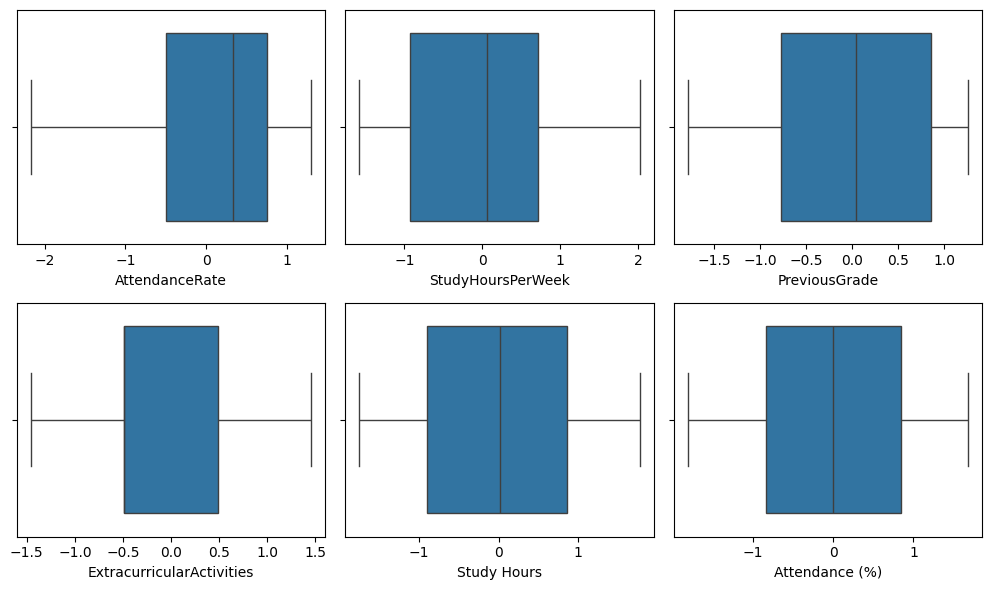

In [293]:
plt.figure(figsize=(10, 6))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=df[col])
plt.tight_layout()
plt.show()

# Разобьём данные на обучающую и тестовую выборки

In [294]:
X = df.drop('FinalGrade', axis=1)
y = df['FinalGrade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Размер X_train:", X_train.shape)
print("Размер X_test:", X_test.shape)
print("Размер y_train:", y_train.shape)
print("Размер y_test:", y_test.shape)

Размер X_train: (800, 9)
Размер X_test: (200, 9)
Размер y_train: (800,)
Размер y_test: (200,)


# Обучим и проверим качество модели KNeighborsRegressor

R^2 модели K-ближайших соседей при n = 1: -1.0154
R^2 модели K-ближайших соседей при n = 2: -0.5156
R^2 модели K-ближайших соседей при n = 3: -0.4313
R^2 модели K-ближайших соседей при n = 4: -0.2774
R^2 модели K-ближайших соседей при n = 5: -0.1961
R^2 модели K-ближайших соседей при n = 6: -0.1860
R^2 модели K-ближайших соседей при n = 7: -0.1461
R^2 модели K-ближайших соседей при n = 8: -0.1379
R^2 модели K-ближайших соседей при n = 9: -0.0958
R^2 модели K-ближайших соседей при n = 10: -0.0879
R^2 модели K-ближайших соседей при n = 11: -0.0727
R^2 модели K-ближайших соседей при n = 12: -0.0676
R^2 модели K-ближайших соседей при n = 13: -0.0793
R^2 модели K-ближайших соседей при n = 14: -0.0868
R^2 модели K-ближайших соседей при n = 15: -0.0745
R^2 модели K-ближайших соседей при n = 16: -0.0618
R^2 модели K-ближайших соседей при n = 17: -0.0603
R^2 модели K-ближайших соседей при n = 18: -0.0433
R^2 модели K-ближайших соседей при n = 19: -0.0388
R^2 модели K-ближайших соседей при n = 2

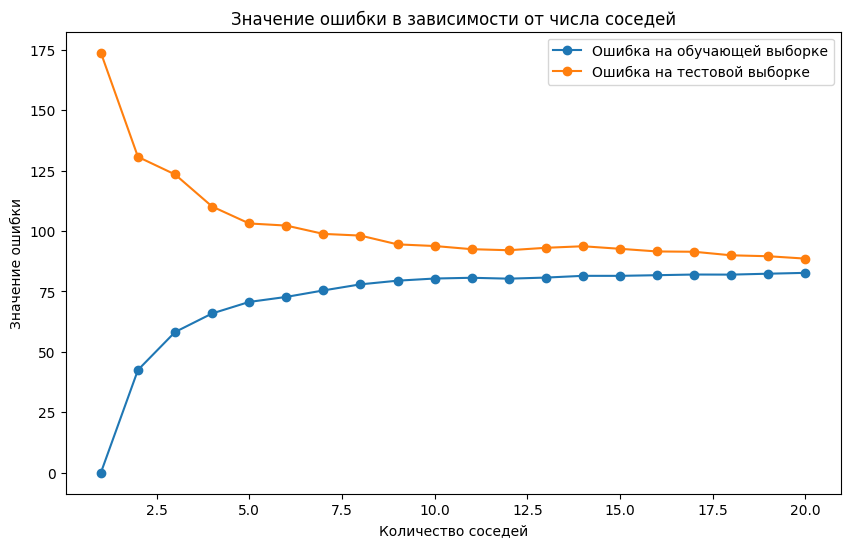

In [295]:
neighbor_range = range(1, 21)
train_errors = []
test_errors = []
r2 = []

for n in neighbor_range:
    # Используем KNeighborsRegressor для задачи регрессии
    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train, y_train)

    # Предсказания на обучающей и тестовой выборках
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)

    # Вычисление ошибок (используем Mean Squared Error для регрессии)
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)

    train_errors.append(train_error)
    test_errors.append(test_error)

    # Рассчитаем R^2
    r2_test = knn.score(X_test, y_test)
    r2.append(r2_test)
    print(f"R^2 модели K-ближайших соседей при n = {n}: {r2_test:.4f}")


plt.figure(figsize=(10, 6))
plt.plot(neighbor_range, train_errors, label="Ошибка на обучающей выборке", marker='o')
plt.plot(neighbor_range, test_errors, label="Ошибка на тестовой выборке", marker='o')
plt.xlabel("Количество соседей")
plt.ylabel("Значение ошибки")
plt.title("Значение ошибки в зависимости от числа соседей")
plt.legend()
plt.show()

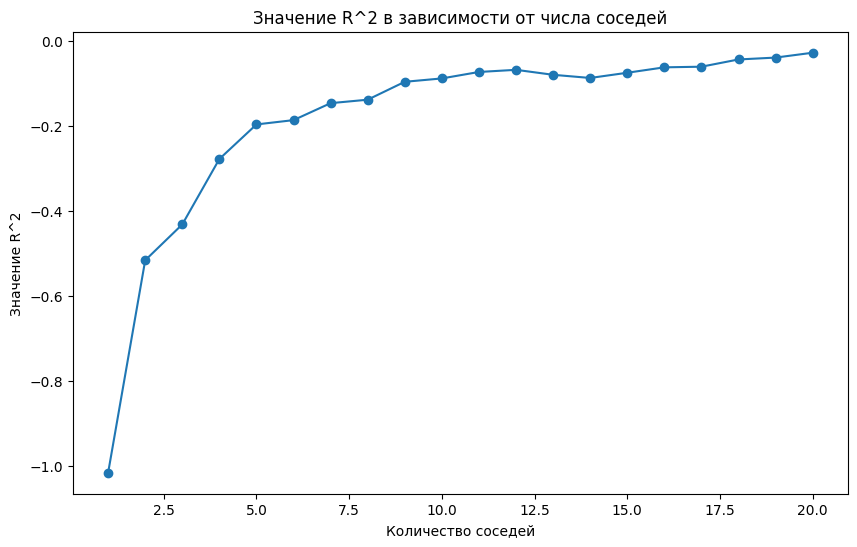

In [296]:
plt.figure(figsize=(10, 6))
plt.plot(neighbor_range, r2, label="R^2", marker='o')
plt.xlabel("Количество соседей")
plt.ylabel("Значение R^2")
plt.title("Значение R^2 в зависимости от числа соседей")
plt.show()

Видим, что наша модель плохо справляется с предсказанием. Она оказалась неподходящей для этого датасета или признаки в целом недостаточно информативны для предсказания.

Попробуем другой вариант - линейную регрессию.

In [297]:
# Создаем и обучаем модель линейной регрессии
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Предсказываем на тестовой выборке
y_test_pred_linear = linear_model.predict(X_test)

# Оцениваем модель
mse_linear = mean_squared_error(y_test, y_test_pred_linear)
r2_linear = r2_score(y_test, y_test_pred_linear)

print(f"Среднеквадратичная ошибка: {mse_linear:.4f}")
print(f"R^2: {r2_linear:.4f}")

Среднеквадратичная ошибка: 85.4076
R^2: 0.0093


Ошибки на обучающей и тестовой выборках по-прежнему слишком высоки.